# Key Insights <a id="Top"></a>
### [1. Salary Comparison: Data Scientists > Data Engineers > Analysts](#title)
### [2. Salary Comparison: California Cities at the top](#Location)
### [3. Hot Keywords in Job Descriptions: PHD, Master, Python, Machine Learning, SQL and more](#JD)
### [4. Higher Company Rating is associated with slightly higher salaries](#rating)
### [5. [Heatmaps] Company Size, Scale and Salaries](#hm)
### [6. Data Science Job Salary Impact Map (Final Regression Result)](#final)

# Table of Contents<a id="TOC"></a>
* [About](#about)
* [Prepare Data](#1)
    * [Import Libraries and Datasets](#1-1)
    * [Clean Data](#1-2)
    * [Prepare Variables for Regression Analysis](#1-3)
* [Methodology](#method)
* [Analysis Process (Codes)](#ap)
* [Key Preliminary Results](#pl)
    * [Job Titles vs Salaries (pie chart, distribution and errorbars)](#title)
    * [Job Descriptions vs Salaries (bar chart and wordcloud](#JD)
    * [Job Locations vs Salaries (bar chart with errorbars)](#Location)
    * [First Combined Regression Model Output](#model1)
* [Model Tuning](#tune1)
    * [Tune the first combined model with Elastic Net](#EN1)
    * [Introduce interaction terms](#int)
    * [Final Model Output](#finaltab)
    * [Multicollinearity](#multi)
* [Final Regression Result in Visualisation](#final)

# About <a id="about"></a>
<a href="#TOC" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Back to Top</a>
## Dataset
This dataset was created by [picklesueat](https://github.com/picklesueat/data_jobs_data) and contains 12,000+ job listing for data science jobs (all assumed to be open positions at the time the dataset was published in July 2020), with features such as:

* Salary Estimate
* Location
* Company Rating
* Job Description
  and more.

## Objectives
* What kind of Data Science jobs get higher salaries? (Job Title, Job Description, EasyApply)
* What kind of companies pay more? (Rating, Company, Size, *Years established (now - Founded)*, Type of ownership, Industry & Sector, Revenue)
* Does job/headquarters location matter to salaries?

## Limitations and Assumptions

* The results only reflet the outcome at the time the dataset was published, which is pressumed to be July 2020. Seasonal variation is disregarded (not a time-series data).
* Somehow remote positions are not found in this dataset, so the impact of pandemic (more jobs becoming remote) on salary cannot be measured.
* The salary estimates come from Glassdoor, which may not reflect the actual salaries.
* The dataset is assumed to reflect the traits of the actual job market.
* The salaries are nominal, not adjusted by living costs or consumer price index.

# Data Preparation <a id="1"></a>

## Import Libraries and Dataset <a id="1-1"></a>
<a href="#TOC" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Back to Top</a>

In [ ]:
import numpy as np 
import pandas as pd

# plots
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from numpy.polynomial.polynomial import polyfit
from matplotlib.patches import Rectangle

# t-test
from scipy import stats

# regression - statsmodels
import statsmodels.regression.linear_model as sm
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

# regression - sklearn
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

# sqrt
from math import sqrt

# Word Cloud
from wordcloud import WordCloud

# function for inserting a row to a location
def Insert_row_(row_number, df, row_value): 
    # Slice the upper half of the dataframe 
    df1 = df[0:row_number]   
    # Store the result of lower half of the dataframe 
    df2 = df[row_number:]  
    # Inser the row in the upper half dataframe 
    df1.loc[row_number]=row_value 
    # Concat the two dataframes 
    df_result = pd.concat([df1, df2]) 
    # Reassign the index labels 
    df_result.index = [*range(df_result.shape[0])] 
    # Return the updated dataframe 
    return df_result

In [ ]:
data_ds=pd.read_csv('../input/data-scientist-jobs/DataScientist.csv')
data_da=pd.read_csv('../input/data-analyst-jobs/DataAnalyst.csv')
data_de=pd.read_csv('../input/data-engineer-jobs/DataEngineer.csv')
data_ba=pd.read_csv('../input/business-analyst-jobs/BusinessAnalyst.csv')

data_ds = data_ds.drop(['Unnamed: 0','index'],axis=1)
data_da = data_da.drop(['Unnamed: 0'],axis=1)
data_ba = data_ba.drop(['Unnamed: 0','index'],axis=1).head(3692) # drop due to columns messed-up

data = pd.concat([data_ds,data_da,data_de,data_ba]).reset_index(drop=True)

## Clean Data <a id="1-2"></a>
<a href="#TOC" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Back to Top</a>

In [ ]:
# Check for missing values
def missing_values_table(df):
    # number of missing values
    mis_val = df.isnull().sum()
    # % of missing values
    mis_val_percent = 100 * mis_val / len(df)
    # make table # axis '0' concat along index, '1' column
    mis_val_table = pd.concat([mis_val,mis_val_percent],axis=1) 
    # rename columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0:'Missing Values',1:'% of Total Values'})
    # sort by column
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]!=0].sort_values(
        '% of Total Values',ascending=False).round(1) #Review
    print("Your selected datset has "+str(df.shape[1])+" columns and "+str(len(df))+" observations.\n"
         "There are "+str(mis_val_table_ren_columns.shape[0])+" columns that have missing values.")
    # return the dataframe with missing info
    return mis_val_table_ren_columns

In [ ]:
# replace rating values in string/bool to float
data['Rating'] = data['Rating'].astype(float)
data['Easy Apply'] = data['Easy Apply'].replace('True',1)

# Replace -1 or -1.0 or '-1' to NaN
data=data.replace(-1,np.nan)
data=data.replace(-1.0,np.nan)
data=data.replace('-1',np.nan)

In [ ]:
#Remove Rating values from Company Name. 
data['Company Name'],_=data['Company Name'].str.split('\n', 1).str
# 1st column after split, 2nd column after split (delete when '_')
# string.split(separator, maxsplit) maxsplit default -1, which means all occurrances

# Split salary into two columns min salary and max salary.
data['Salary Estimate'],_=data['Salary Estimate'].str.split('(', 1).str

#exclude hourly rating salaries
data=data[(data['Salary Estimate'].str.contains(' Per Hour'))==False].reset_index(drop=True)

# Split salary into two columns min salary and max salary.
# lstrip is for removing leading characters; rstrip is for removing rear characters
data['Min_Salary'],data['Max_Salary']=data['Salary Estimate'].str.split('-').str
data['Min_Salary']=data['Min_Salary'].str.strip(' ').str.lstrip('$').str.rstrip('K').fillna(0).astype('int')
data['Max_Salary']=data['Max_Salary'].str.strip(' ').str.lstrip('$').str.rstrip('K').fillna(0).astype('int')

# To estimate the salary with regression and other analysis, better come up with one number: Est_Salary = (Min_Salary+Max_Salary)/2
data['Est_Salary']=(data['Min_Salary']+data['Max_Salary'])/2

# Create a variable for how many years a firm has been founded
data['Years_Founded'] = 2020 - data['Founded'].astype(float)

# Separate 'City' & 'State' from job 'Location'
data['City'],data['State'] = data['Location'].str.split(', ',1).str
data['HQCity'],data['HQState'] = data['Headquarters'].str.split(', ',1).str

# Clean up duplicated city names in State's name
data['State']=data['State'].replace('Arapahoe, CO','CO')
data['State']=data['State'].replace('Los Angeles, CA','CA')
data['HQState']=data['HQState'].replace('NY (US), NY','NY')



In [ ]:
# Group up number of hires by company's revenue
RevCount = data.groupby('Revenue')[['Job Title']].count().reset_index().rename(columns={'Job Title':'Hires'}).sort_values(
    'Hires', ascending=False).reset_index(drop=True)
#Make the Revenue column clean
RevCount["Revenue_USD"]=['Unknown','10+ billion','100-500 million','50-100 million','2-5 billion','10-25 million','1-2 billion','1-5 million','25-50 million','5-10 billion','<1 million','0.5-1 billion','5-10 million']
#Merge the new Revenue back to data
RevCount2 = RevCount[['Revenue','Revenue_USD']]
RevCount = RevCount.merge(data, on='Revenue',how='left')
data=data.merge(RevCount2,on='Revenue',how='left')

In [ ]:
missing_values_table(data)

## Prepare Variables for Regression Analysis <a id="1-3"></a> 
<a href="#TOC" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Back to Top</a>

In [ ]:
# create a new dataset from original data
text_Analysis = data[['Job Title','Job Description','Est_Salary','Max_Salary','Min_Salary','City','State','Easy Apply','Revenue_USD','Rating','Size','Industry','Sector','Type of ownership','Years_Founded','Company Name','HQState']]

In [ ]:
# set minimum sample size for t-test and other statistical computings.
ssize = 30

In [ ]:
# write get_keyword function
def get_keyword(x, note, VarSet):
   x_ = x.split(" ")
   keywords = []
   try:
      for word in x_:
         if word + note in np.asarray(VarSet):
            keywords.append(word + note)
   except:
      return -1

   return keywords

In [ ]:
#Remove special characters.
text_Analysis['Revenue_USD'] = text_Analysis['Revenue_USD'].replace('Unknown','RevUnknown')
text_Analysis['Size'] = text_Analysis['Size'].replace('Unknown','SizeUnknown')
text_Analysis['Sector'] = text_Analysis['Sector'].replace('[^A-Za-z0-9]+', '_',regex=True).replace(['Government','Unknown'],['GovSec','SectorUnknown'])
text_Analysis['Industry'] = text_Analysis['Industry'].replace('[^A-Za-z0-9]+', '_',regex=True).replace('Unknown','IndUnknown')
text_Analysis['Type of ownership'] = text_Analysis['Type of ownership'].replace('[^A-Za-z0-9]+', '_',regex=True).replace('Unknown','OwnUnknown')

In [ ]:
#Rename column name for running regression later.
text_Analysis = text_Analysis.rename(columns={"Easy Apply":"Easy_Apply"})

### Get Keyword Variables from Job Titles

In [ ]:
# remove special characters and unify some word use
text_Analysis['Job_title_2']= text_Analysis['Job Title'].str.upper().replace('[^A-Za-z0-9]+', ' ',regex=True)
text_Analysis['Job_title_2']= text_Analysis['Job_title_2'].str.upper().replace(
    ['Â','AND ','WITH ','SYSTEMS','OPERATIONS','ANALYTICS','SERVICES','ENGINEERS','NETWORKS','GAMES','MUSICS','INSIGHTS','SOLUTIONS','JR ','MARKETS','STANDARDS','FINANCE','PRODUCTS','DEVELOPERS','SR ',' 2'],
    ['','','','SYSTEM','OPERATION','ANALYTIC','SERVICE','ENGINEER','NETWORK','GAME','MUSIC','INSIGHT','SOLUTION','JUNIOR ','MARKET','STANDARD','FINANCIAL','PRODUCT','DEVELOPER','SENIOR ',' II'],regex=True)

# unify some word use
text_Analysis['Job_title_2']= text_Analysis['Job_title_2'].str.upper().replace(
    ['BUSINESS INTELLIGENCE','INFORMATION TECHNOLOGY','QUALITY ASSURANCE','USER EXPERIENCE','USER INTERFACE','DATA WAREHOUSE','DATA ANALYST','DATA BASE','DATA QUALITY','DATA GOVERNANCE','BUSINESS ANALYST','DATA MANAGEMENT','REPORTING ANALYST','BUSINESS DATA','SYSTEM ANALYST','DATA REPORTING','QUALITY ANALYST','DATA ENGINEER','BIG DATA','SOFTWARE ENGINEER','MACHINE LEARNING','FULL STACK','DATA SCIENTIST','DATA SCIENCE','DATA CENTER','ENTRY LEVEL','NEURAL NETWORK','SYSTEM ENGINEER',' ML '],
    ['BI','IT','QA','UX','UI','DATA_WAREHOUSE','DATA_ANALYST','DATABASE','DATA_QUALITY','DATA_GOVERNANCE','BUSINESS_ANALYST','DATA_MANAGEMENT','REPORTING_ANALYST','BUSINESS_DATA','SYSTEM_ANALYST','DATA_REPORTING','QUALITY_ANALYST','DATA_ENGINEER','BIG_DATA','SOFTWARE_ENGINEER','MACHINE_LEARNING','FULL_STACK','DATA_SCIENTIST','DATA_SCIENCE','DATA_CENTER','ENTRY_LEVEL','NEURAL_NETWORK','SYSTEM_ENGINEER',' MACHINE_LEARNING '],regex=True)

# unify some word use
text_Analysis['Job_title_2']= text_Analysis['Job_title_2'].str.upper().replace(
    ['DATA_ENGINEER JUNIOR','DATA_ENGINEER SENIOR','DATA  REPORTING_ANALYST','DATA ','BIG_DATA '],
    ['JUNIOR DATA_ENGINEER','SENIOR DATA_ENGINEER','DATA_REPORTING_ANALYST','DATA_','BIG_DATA_'],regex=True)

# get top keywords
s = text_Analysis['Job_title_2'].str.split(expand=True).stack().value_counts().reset_index().rename(
    columns={'index':'KW',0:'Count'})
S = s[s['Count']>ssize]

# get keywords from each row
text_Analysis['KW'] = text_Analysis['Job_title_2'].apply(lambda x: get_keyword(x,'',S['KW']))

# create dummy columns by keywords
kwdummy = pd.get_dummies(text_Analysis['KW'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True).replace(np.nan,0)

### Get Keyword Variables from Job Descriptions

In [ ]:
# Create a list of big data buzzwords to see if those words in JD would influence the salary
buzzwords = ['COMPUTER_SCIENCE','MASTER','MBA','SQL','PYTHON','R','PHD','BUSINESS_ANALYTICS','SAS','PMP','SCRUM_MASTER','STATISTICS','MATHEMATICS','MACHINE_LEARNING','ARTIFICIAL_INTELLIGENCE','ECONOMICS','TABEAU','AWS','AZURE','POWER_BI','ALGORITHM','DEEP_LEARNING','NEURAL_NETWORK','NATURAL_LANGUAGE_PROCESSING','DECISION_TREE','REGRESSION','CLUSTER','ORACLE','EXCEL','TENSORFLOW','HADOOP','SPARK','NOSQL','SAP','ETL','API','PLSQL','MONGODB','POSTGRESQL','ELASTICSEARCH','REDIS','MYSQL','FIREBASE','SQLITE','CASSANDRA','DYNAMODB','OLTP','OLAP','DEVOPS','PLATFORM','NETWORK','APACHE','SECURITY','MARKDOWN']

In [ ]:
# remove special characters and unify some word use
text_Analysis['Job_Desc2'] = text_Analysis['Job Description'].replace('[^A-Za-z0-9]+', ' ',regex=True)
text_Analysis['Job_Desc2'] = text_Analysis['Job_Desc2'].str.upper().replace(
    ['COMPUTER SCIENCE','ENGINEERING DEGREE',' MS ','BUSINESS ANALYTICS','SCRUM MASTER','MACHINE LEARNING',' ML ','POWER BI','ARTIFICIAL INTELLIGENCE',' AI ','ALGORITHMS','DEEP LEARNING','NEURAL NETWORK','NATURAL LANGUAGE PROCESSING','DECISION TREE','CLUSTERING','PL SQL'],
    ['COMPUTER_SCIENCE','ENGINEERING_DEGREE',' MASTER ','BUSINESS_ANALYTICS','SCRUM_MASTER','MACHINE_LEARNING',' MACHINE_LEARNING ','POWER_BI','ARTIFICIAL_INTELLIGENCE',' ARTIFICIAL_INTELLIGENCE ','ALGORITHM','DEEP_LEARNING','NEURAL_NETWORK','NATURAL_LANGUAGE_PROCESSING','DECISION_TREE','CLUSTER','PLSQL'],regex=True)

# Count the JD keywords.
S2 = text_Analysis['Job_Desc2'].str.split(expand=True).stack().value_counts().reset_index().rename(
    columns={'index':'KW',0:'Count'})
S2 = S2[S2['KW'].isin(buzzwords)].reset_index(drop=True)
S2['KWJD'] = S2['KW'] + '_JD'
S2 = S2[S2['Count']>ssize]

# get keywords from each row
text_Analysis['JDKW'] = text_Analysis['Job_Desc2'].apply(lambda x: get_keyword(x,'_JD',S2['KWJD']))

# create dummy columns by keywords
kwdummy = pd.get_dummies(text_Analysis['JDKW'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)

In [ ]:
# let's see if number of buzzwords contained or how wordy the JD is would have impact.
text_Analysis['JDKWlen']=text_Analysis['JDKW'].str.len()
text_Analysis['JDlen']=text_Analysis['Job Description'].str.len()

### Get Job Location Variables

In [ ]:
## State ##
# Count the states frequency for t-test later
S3 = text_Analysis['State'].value_counts().reset_index().rename(
    columns={'index':'State','State':'Count'})
S3_Top = S3[S3['Count']>ssize]

# create dummy columns by State
kwdummy = pd.get_dummies(text_Analysis['State'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)

## City ##
text_Analysis['City']=text_Analysis['City'].str.replace(' ','_',regex=True)

# Count the city frequency for t-test later
S35 = text_Analysis['City'].value_counts().reset_index().rename(
    columns={'index':'City','City':'Count'})
S35_Top = S35[S35['Count']>ssize]

# create dummy columns by City
kwdummy = pd.get_dummies(text_Analysis[text_Analysis['City'].isin(np.asarray(S35_Top['City']))]['City'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)

## State where companies Headquarters locate at  ##
# Count the HQState frequency for t-test later
S31 = text_Analysis['HQState'].value_counts().reset_index().rename(
    columns={'index':'HQState','HQState':'Count'}).replace(0,'Unknown_State')
S31['HQState_HQ'] = [s + '_HQ' for s in S31['HQState']]
S31_Top = S31[S31['Count']>ssize]

# create dummy columns by HQ State
kwdummy = pd.get_dummies(S31_Top['HQState_HQ'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
S31_Top2 = S31_Top.merge(kwdummy,left_index=True,right_index=True,how='left').drop(['Count'],axis=1)
text_Analysis = text_Analysis.merge(S31_Top2,on='HQState',how='left').replace(np.nan,0)

### Get More Variables: Revenue, Size, Sector and Type of Ownership

In [ ]:
# create dummy columns by Revenue
kwdummy = pd.get_dummies(text_Analysis['Revenue_USD'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)
# Count the Revenue frequency for t-test later
S4 = text_Analysis['Revenue_USD'].value_counts().reset_index().rename(
    columns={'index':'Revenue_USD','Revenue_USD':'Count'})
S4_Top = S4[(S4['Count']>ssize) & (S4['Revenue_USD']!=0)]

# create dummy columns by Size
kwdummy = pd.get_dummies(text_Analysis['Size'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)
# Count the Size frequency for t-test later
S5 = text_Analysis['Size'].value_counts().reset_index().rename(
    columns={'index':'Size','Size':'Count'})
S5_Top = S5[(S5['Count']>ssize) & (S5['Size']!=0)]

# create dummy columns by Sector
kwdummy = pd.get_dummies(text_Analysis['Sector'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)
# Count the Sector frequency for t-test later
S6 = text_Analysis['Sector'].value_counts().reset_index().rename(
    columns={'index':'Sector','Sector':'Count'})
S6 = S6[S6['Sector']!=0]
S6_Top = S6[(S6['Count']>ssize)]

# create dummy columns by Type of Ownership
kwdummy = pd.get_dummies(text_Analysis['Type of ownership'].apply(pd.Series).stack()).sum(level=0)
kwdummy = kwdummy.apply(lambda x: [y if y <= 1 else 1 for y in x])
# merge back the dummy columns to the main dataset
text_Analysis = text_Analysis.merge(kwdummy,left_index=True,right_index=True,how='left').replace(np.nan,0)
# Count the Type of ownership frequency for t-test later
S8 = text_Analysis['Type of ownership'].value_counts().reset_index().rename(
    columns={'index':'Type_of_ownership','Type of ownership':'Count'})
S8_Top = S8[(S8['Count']>ssize) & (S8['Type_of_ownership']!=0)]

# Methodology: Backward-stepwise Regression <a id="method"></a>
<a href="#TOC" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Back to Top</a>

This Backward-stepwise Regression is designed for the scenario that**, within a limited time, needs to run regression analysis with the dataset containing lots of categorical data as independent variables.** 

Visit [this notebook](https://www.kaggle.com/gawainlai/backward-stepwise-regression-v1-0) for more details.

Key steps:

1. Categorical variable groups: for example, city, state, job title keywords...etc.
2. Create dummy variables for each value whose presence in the dataset is at least >29.
3. After splitting training/validating/testing datasets, perform T-tests and remove variables by p-value threshold 0.1.
4. Perform backward-stepwise regression (p-value threshold 0.05) on variables that passed the T-tests in each variable group.
5. Include all the variables having passed the preliminary regression models and re-run backward-stepwise regression.
6. Plot the validation errors by Elastic Net alpha's to see how to tune the model (remove or add variables). At the same time, observe multicollinearity, consider interaction terms...etc.
7. Compare the models and make the final decision.
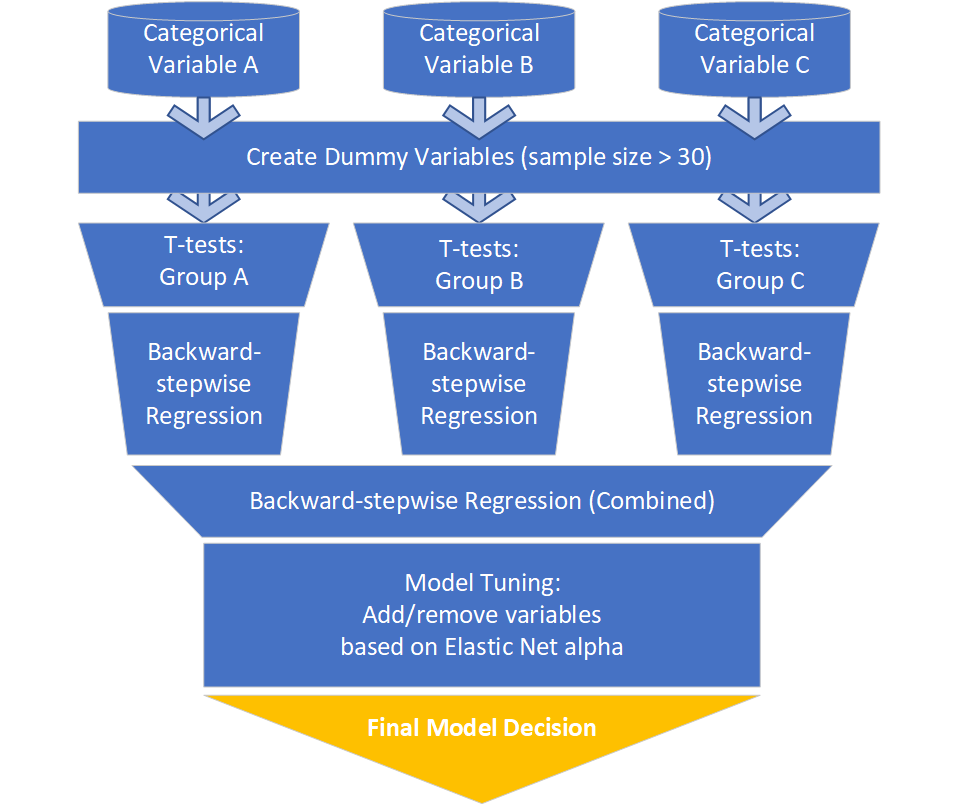

In [ ]:
def splittingSets(df, y):
    X = df.drop([y],axis=1)
    y = df[y]

    X_int, X_test, y_int, y_test = train_test_split(X,y,shuffle=False,test_size=0.2,random_state=15)
    X_train, X_val, y_train, y_val = train_test_split(X_int,y_int,shuffle=False,test_size=0.25,random_state=15)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
def ttest(setX):
    text_columns = list(X_train.columns)
    ttests=[]
    for word in text_columns:
        if word in set(setX):
            ttest = stats.ttest_ind(y_train[X_train[word]==1],
                                    y_train[X_train[word]==0])
            ttests.append([word,ttest])
    ttests = pd.DataFrame(ttests,columns=['Var','R'])
    ttests['R']=ttests['R'].astype(str).replace(['Ttest_indResult\(statistic=','pvalue=','\)'],['','',''],regex=True)
    ttests['Statistic'],ttests['P-value']=ttests['R'].str.split(', ',1).str
    ttests=ttests.drop(['R'],axis=1).sort_values('P-value',ascending=True)
    return ttests

In [ ]:
def VarFromTtests(ttests_var,ttest_p):
    ttest_var_pass = ttests_var[ttests_var['P-value'].astype(float)<ttest_p].reset_index(drop=True)
    ttest_pass = list(ttest_var_pass['Var'])
    
    #build table for variables from ttest results
    ttests_var_pass_KW = list(ttest_pass)
    ttests_var_pass_KW.insert(0,'Const')
    ttests_var_pass_KW = pd.DataFrame(ttests_var_pass_KW,columns=['Var'])

    #list of variables to be put in the model
    model_var = list(ttest_pass)
    model_var.insert(0,'Const')

    #list of variables removed
    var_remove = []
    
    return ttests_var_pass_KW, model_var, var_remove, ttest_pass

In [ ]:
def buildmodel(X_opt, var_name):
    Mod = sm.OLS(endog = y_train, exog = X_opt).fit() 
    results_summary = Mod.summary(xname=var_name)
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(
        sm.OLS(endog = y_train, exog = X_opt).exog, i) for i in range(
        1, sm.OLS(endog = y_train, exog = X_opt).exog.shape[1])]
    vif = Insert_row_(0, vif, np.nan)
    return results_summary, vif, Mod

In [ ]:
def resulttable(results_summary):
    results_as_html = results_summary.tables[1].as_html()
    results_as_html = pd.read_html(results_as_html, header=0, index_col=0)[0]
    result_data = pd.DataFrame(results_as_html)
    return result_data

In [ ]:
def resulttables(results_summary, vif):
    results_as_html0 = results_summary.tables[0].as_html()
    results_as_html1 = results_summary.tables[1].as_html()
    results_as_html2 = results_summary.tables[2].as_html()
    results_as_html0 = pd.read_html(results_as_html0, header=0, index_col=0)[0]
    results_as_html1 = pd.read_html(results_as_html1, header=0, index_col=0)[0]
    results_as_html2 = pd.read_html(results_as_html2, header=0, index_col=0)[0]
    result_data0 = pd.DataFrame(results_as_html0)
    result_data1 = pd.DataFrame(results_as_html1).reset_index()
    result_data1 = result_data1.merge(vif, right_index=True, left_index=True)
    result_data2 = pd.DataFrame(results_as_html2)
    return result_data0, result_data1, result_data2

In [ ]:
# Create Backward Stepwise functions
def backwardeliminate(model_var, var_remove, ttest_pass_KW, ttest_pass):
    for ele in model_var:
        if ele in var_remove:
            model_var.remove(ele)
    ttest_pass_KW = ttest_pass_KW[ttest_pass_KW['Var'].isin(model_var)]
    var_idx = ttest_pass_KW['Var'].index.tolist()
    X_train0 = X_train[ttest_pass]
    X_train1 = np.append(arr = np.ones((len(X_train0), 1)).astype(int),
                         values = X_train0, axis = 1)
    X_opt = X_train1[:,var_idx]
    var_name = list(ttest_pass_KW['Var'])
    return X_opt, var_name

In [ ]:
def scalibility(FINAL_MODEL_NAME, Mod_Final_1, Mod_Final_2):
    global modelperform
    X_train0 = X_train[Mod_Final_2[Mod_Final_2['index']!='Const']['index']]
    X_train1 = np.append(arr = np.ones((len(X_train0), 1)).astype(int),values = X_train0, axis = 1)

    X_val0 = X_val[Mod_Final_2[Mod_Final_2['index']!='Const']['index']]
    X_val1 = np.append(arr = np.ones((len(X_val0), 1)).astype(int),values = X_val0, axis = 1)

    X_test0 = X_test[Mod_Final_2[Mod_Final_2['index']!='Const']['index']]
    X_test1 = np.append(arr = np.ones((len(X_test0), 1)).astype(int),values = X_test0, axis = 1)
        
    new_row = {'Model': FINAL_MODEL_NAME,'Adj. R-squared': Mod_Final_1.iloc[0][2],
               'AIC': Mod_Final_1.iloc[4][2],'BIC': Mod_Final_1.iloc[5][2],
               'R2':r2_score(np.asarray(y_train),sm.OLS(endog = y_train, exog = X_train1).fit().predict(X_train1)),
               'RMSE':sqrt(mean_squared_error(np.asarray(y_train),
                                       sm.OLS(endog = y_train, exog = X_train1).fit().predict(X_train1))),
               'R2_val':r2_score(np.asarray(y_val),sm.OLS(endog = y_train, exog = X_train1).fit().predict(X_val1)),
               'RMSE_val':sqrt(mean_squared_error(np.asarray(y_val),
                                       sm.OLS(endog = y_train, exog = X_train1).fit().predict(X_val1))),
               'R2_test':r2_score(np.asarray(y_test),sm.OLS(endog = y_train, exog = X_train1).fit().predict(X_test1)),
               'RMSE_test':sqrt(mean_squared_error(np.asarray(y_test),
                                       sm.OLS(endog = y_train, exog = X_train1).fit().predict(X_test1)))}

    pd.options.display.float_format = '{:.4f}'.format
    modelperform = modelperform.append(new_row, ignore_index=True)
    
    return modelperform, X_train1, X_val1, X_test1

In [ ]:
def multicol(Coef_Final):
    multivlsit = Coef_Final.index.tolist()
    multivlsit.remove('Const')
    corr_df = X_train[multivlsit].corr(method='pearson')
    mask = np.zeros_like(corr_df)
    mask[np.triu_indices_from(mask)] = True
    
    sns.set(style='white')
    fig = plt.figure(figsize=(13, 13))
    sns.heatmap(corr_df, cmap='RdYlGn_r', vmax = 1.0, vmin = -1.0, mask = mask, linewidths = 2.5)
    plt.yticks(rotation = 0)
    plt.xticks(rotation = 90)
    plt.show()

In [ ]:
def addTopInteractions():
    global X_train, X_val, X_test, Interactions_Top
    X_train0 = X_train[Mod_Final_2[Mod_Final_2['index']!='Const']['index']]
    baseline = np.mean(cross_val_score(linear_model.LinearRegression(), X_train0, y_train, scoring='r2', cv=3, n_jobs=1))
    interactions = list()
    for feature_A in X_train0.columns:
        for feature_B in X_train0.columns:
            if feature_A > feature_B:
                X_train0['interaction'] = X_train0[feature_A] * X_train0[feature_B]
                score = np.mean(cross_val_score(linear_model.LinearRegression(), X_train0, y_train, scoring='r2',
                                       cv=3, n_jobs=1))
                if score > baseline:
                    interactions.append((feature_A, feature_B, round(score,3)))

    Interactions = pd.DataFrame(interactions)
    Interactions = Interactions.sort_values(2,ascending=False).reset_index(drop=True)
    Interactions_Top = Interactions.iloc[0:9,:]
    Interactions_Top['inter'] = Interactions_Top[0]+'*'+Interactions_Top[1]

    for i in Interactions_Top.index:
        X_train[Interactions_Top.iloc[i]['inter']] = X_train[
            Interactions_Top.iloc[i][0]]*X_train[Interactions_Top.iloc[i][1]]
        X_val[Interactions_Top.iloc[i]['inter']] = X_val[
            Interactions_Top.iloc[i][0]]*X_val[Interactions_Top.iloc[i][1]]
        X_test[Interactions_Top.iloc[i]['inter']] = X_test[
            Interactions_Top.iloc[i][0]]*X_test[Interactions_Top.iloc[i][1]]
        if sum(X_train[Interactions_Top.iloc[i]['inter']]) < ssize:
            X_train = X_train.iloc[:,0:-1]

    X_val = X_val[X_train.columns]
    X_test = X_test[X_test.columns]
    return X_train, X_val, X_test, Interactions_Top

In [ ]:
def ElasticNetPlot(alpha_max, alpha_step, L1_wt_value):
    ols_rmse_val=sqrt(mean_squared_error(np.asarray(y_val),
                                       sm.OLS(endog = y_train, exog = X_train1).fit().predict(X_val1)))

    EN_rmse_val=[]
    for alpha in np.arange(0, alpha_max, alpha_step):
        # L1_wt: (0)Ridge - (1)Lasso
        EN_rmse_val.append(sqrt(mean_squared_error(np.asarray(y_val),sm.OLS(
            endog = y_train, exog = X_train1).fit_regularized(method='elastic_net', alpha=alpha, L1_wt = L1_wt_value).predict(X_val1))))

    # plot rmse
    fig, ax = plt.subplots(figsize=(13, 7))
    plt.plot(np.arange(0, alpha_max, alpha_step), EN_rmse_val, 'ro')
    plt.axhline(y=ols_rmse_val, color='g', linestyle='--')
    plt.title("Elatic Net Validation RMSE", fontsize=16)
    plt.xlabel("Model Simplicity$\longrightarrow$")
    plt.ylabel("RMSE")
    plt.show()

In [ ]:
def coefficientbars(alpha_value, L1_wt_value, Mod_Final_2):
    mod_min_val_err = sm.OLS(endog = y_train, exog = X_train1).fit_regularized(method='elastic_net', alpha=alpha_value, L1_wt = L1_wt_value)
    regularized_regression_parameters = mod_min_val_err.params.reset_index()

    sns.set(style='white')
    reg_fit = Mod_Final_2['index'].reset_index()
    reg_fit = reg_fit.merge(regularized_regression_parameters, right_index=True, left_index=True).drop(
        ['level_0','index_y'],axis=1).rename(columns={'index_x':'Var',0:'Coefficient'}).sort_values(
        'Coefficient',ascending=False).reset_index(drop=True)
    reg_fit = reg_fit[reg_fit['Var']!='Const']

    fig = plt.figure(figsize=(13, 5))
    sns.barplot(x='Var',y='Coefficient',data=reg_fit).set(xlabel="",ylabel="Salary Performance \n Against Average")

    plt.xticks(rotation=45,horizontalalignment='right')
    plt.show()

# Analysis Process (Codes) <a id="ap"></a>
<a href="#TOC" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Back to Top</a>

In [ ]:
ssize = 30 # set minimum sample size for each variable
ttest_p = 0.1 # set p-value threshold for t-test
regr_p = 0.05 # set p-value threshold for eliminating variables from regression

X_train, X_val, X_test, y_train, y_val, y_test = splittingSets(text_Analysis, 'Est_Salary')
finalVar=['Years_Founded','Rating','JDKWlen','JDlen','Easy_Apply']

# Job Titles
ttests_title = ttest(s[(s['Count']>=ssize)&(s['KW']!=0)]['KW'])
ttests_title_pass_KW, model_title, title_remove, ttests_title_pass = VarFromTtests(ttests_title, ttest_p)
X_opt_title, title_name = backwardeliminate(model_title, title_remove, ttests_title_pass_KW, ttests_title_pass)
Mod_title, VIF_title, mod_title = buildmodel(X_opt_title, title_name)
Coef_title = resulttable(Mod_title)

i = max(Coef_title['P>|t|'])
while i > regr_p:
    if Coef_title[Coef_title['P>|t|']==i].index.values[0] != 'Const':
        title_remove.append(Coef_title[Coef_title['P>|t|']==i].index.values[0])
        X_opt_title, title_name = backwardeliminate(model_title, title_remove, ttests_title_pass_KW, ttests_title_pass)
        Mod_title, VIF_title, mod_title = buildmodel(X_opt_title, title_name)
        Coef_title = resulttable(Mod_title)
        i = max(Coef_title['P>|t|'])
    else:
        continue

finalVar += Coef_title['coef'].index.tolist()
Mod_title_1,Mod_title_2,Mod_title_3 = resulttables(Mod_title, VIF_title)

# JD
ttests_JD = ttest(S2[(S2['Count']>=ssize)&(S2['KW']!=0)]['KWJD']) 
ttests_JD_pass_KW, model_JD, JD_remove, ttests_JD_pass = VarFromTtests(ttests_JD, ttest_p)
X_opt_JD, JD_name = backwardeliminate(model_JD, JD_remove, ttests_JD_pass_KW, ttests_JD_pass)
Mod_JD, VIF_JD, mod_JD = buildmodel(X_opt_JD, JD_name)
Coef_JD = resulttable(Mod_JD)

i = max(Coef_JD['P>|t|'])
while i > regr_p:
    if Coef_JD[Coef_JD['P>|t|']==i].index.values[0] != 'Const':
        JD_remove.append(Coef_JD[Coef_JD['P>|t|']==i].index.values[0])
        X_opt_JD, JD_name = backwardeliminate(model_JD, JD_remove, ttests_JD_pass_KW, ttests_JD_pass)
        Mod_JD, VIF_JD, mod_JD = buildmodel(X_opt_JD, JD_name)
        Coef_JD = resulttable(Mod_JD)
        i = max(Coef_JD['P>|t|'])
    else:
        continue

finalVar += Coef_JD['coef'].index.tolist()
Mod_JD_1,Mod_JD_2,Mod_JD_3 = resulttables(Mod_JD, VIF_JD)

# state
ttests_State = ttest(S3[(S3['Count']>=ssize)&(S3['State']!=0)]['State'])
ttests_State_pass_KW, model_State, State_remove, ttests_State_pass = VarFromTtests(ttests_State, ttest_p)
X_opt_State, State_name = backwardeliminate(model_State, State_remove, ttests_State_pass_KW, ttests_State_pass)
Mod_State, VIF_State, mod_State = buildmodel(X_opt_State, State_name)
Coef_State = resulttable(Mod_State)

i = max(Coef_State['P>|t|'])
while i > regr_p:
    if Coef_State[Coef_State['P>|t|']==i].index.values[0] != 'Const':
        State_remove.append(Coef_State[Coef_State['P>|t|']==i].index.values[0])
        X_opt_State, State_name = backwardeliminate(model_State, State_remove, ttests_State_pass_KW, ttests_State_pass)
        Mod_State, VIF_State, mod_State = buildmodel(X_opt_State, State_name)
        Coef_State = resulttable(Mod_State)
        i = max(Coef_State['P>|t|'])
    else:
        continue

finalVar += Coef_State['coef'].index.tolist()
Mod_State_1,Mod_State_2,Mod_State_3 = resulttables(Mod_State, VIF_State)

# city
ttests_city = ttest(S35[(S35['Count']>=ssize)&(S35['City']!=0)]['City'])
ttests_city_pass_KW, model_city, city_remove, ttests_city_pass = VarFromTtests(ttests_city, ttest_p)
X_opt_city, city_name = backwardeliminate(model_city, city_remove, ttests_city_pass_KW, ttests_city_pass)
Mod_city, VIF_city, mod_city = buildmodel(X_opt_city, city_name)
Coef_city = resulttable(Mod_city)

i = max(Coef_city['P>|t|'])
while i > regr_p:
    if Coef_city[Coef_city['P>|t|']==i].index.values[0] != 'Const':
        city_remove.append(Coef_city[Coef_city['P>|t|']==i].index.values[0])
        X_opt_city, city_name = backwardeliminate(model_city, city_remove, ttests_city_pass_KW, ttests_city_pass)
        Mod_city, VIF_city, mod_city = buildmodel(X_opt_city, city_name)
        Coef_city = resulttable(Mod_city)
        i = max(Coef_city['P>|t|'])
    else:
        continue

finalVar += Coef_city['coef'].index.tolist()
Mod_city_1,Mod_city_2,Mod_city_3 = resulttables(Mod_city, VIF_city)

# HQ state
ttests_HQState = ttest(S31[(S31['Count']>=ssize)&(S31['HQState_HQ']!=0)]['HQState_HQ'])
ttests_HQState_pass_KW, model_HQState, HQState_remove, ttests_HQState_pass = VarFromTtests(ttests_HQState, ttest_p)
X_opt_HQState, HQState_name = backwardeliminate(model_HQState, HQState_remove, ttests_HQState_pass_KW, ttests_HQState_pass)
Mod_HQState, VIF_HQState, mod_HQState = buildmodel(X_opt_HQState, HQState_name)
Coef_HQState = resulttable(Mod_HQState)

i = max(Coef_HQState['P>|t|'])
while i > regr_p:
    if Coef_HQState[Coef_HQState['P>|t|']==i].index.values[0] != 'Const':
        HQState_remove.append(Coef_HQState[Coef_HQState['P>|t|']==i].index.values[0])
        X_opt_HQState, HQState_name = backwardeliminate(model_HQState, HQState_remove, ttests_HQState_pass_KW, ttests_HQState_pass)
        Mod_HQState, VIF_HQState, mod_HQState = buildmodel(X_opt_HQState, HQState_name)
        Coef_HQState = resulttable(Mod_HQState)
        i = max(Coef_HQState['P>|t|'])
    else:
        continue

finalVar += Coef_HQState['coef'].index.tolist()
Mod_HQState_1,Mod_HQState_2,Mod_HQState_3 = resulttables(Mod_HQState, VIF_HQState)

# Revenue
ttests_Revenue = ttest(S4[(S4['Count']>=ssize)&(S4['Revenue_USD']!=0)]['Revenue_USD'])
ttests_Revenue_pass_KW, model_Revenue, Revenue_remove, ttests_Revenue_pass = VarFromTtests(ttests_Revenue, ttest_p)
X_opt_Revenue, Revenue_name = backwardeliminate(model_Revenue, Revenue_remove, ttests_Revenue_pass_KW, ttests_Revenue_pass)
Mod_Revenue, VIF_Revenue, mod_Revenue = buildmodel(X_opt_Revenue, Revenue_name)
Coef_Revenue = resulttable(Mod_Revenue)

i = max(Coef_Revenue['P>|t|'])
while i > regr_p:
    if Coef_Revenue[Coef_Revenue['P>|t|']==i].index.values[0] != 'Const':
        Revenue_remove.append(Coef_Revenue[Coef_Revenue['P>|t|']==i].index.values[0])
        X_opt_Revenue, Revenue_name = backwardeliminate(model_Revenue, Revenue_remove, ttests_Revenue_pass_KW, ttests_Revenue_pass)
        Mod_Revenue, VIF_Revenue, mod_Revenue = buildmodel(X_opt_Revenue, Revenue_name)
        Coef_Revenue = resulttable(Mod_Revenue)
        i = max(Coef_Revenue['P>|t|'])
    else:
        continue

finalVar += Coef_Revenue['coef'].index.tolist()
Mod_Revenue_1,Mod_Revenue_2,Mod_Revenue_3 = resulttables(Mod_Revenue, VIF_Revenue)

# Size
ttests_Size = ttest(S5[(S5['Count']>=ssize)&(S5['Size']!=0)]['Size'])
ttests_Size_pass_KW, model_Size, Size_remove, ttests_Size_pass = VarFromTtests(ttests_Size, ttest_p)
X_opt_Size, Size_name = backwardeliminate(model_Size, Size_remove, ttests_Size_pass_KW, ttests_Size_pass)
Mod_Size, VIF_Size, mod_Size = buildmodel(X_opt_Size, Size_name)
Coef_Size = resulttable(Mod_Size)

i = max(Coef_Size['P>|t|'])
while i > regr_p:
    if Coef_Size[Coef_Size['P>|t|']==i].index.values[0] != 'Const':
        Size_remove.append(Coef_Size[Coef_Size['P>|t|']==i].index.values[0])
        X_opt_Size, Size_name = backwardeliminate(model_Size, Size_remove, ttests_Size_pass_KW, ttests_Size_pass)
        Mod_Size, VIF_Size, mod_Size = buildmodel(X_opt_Size, Size_name)
        Coef_Size = resulttable(Mod_Size)
        i = max(Coef_Size['P>|t|'])
    else:
        continue

finalVar += Coef_Size['coef'].index.tolist()
Mod_Size_1,Mod_Size_2,Mod_Size_3 = resulttables(Mod_Size, VIF_Size)

# Sector
ttests_Sector = ttest(S6[(S6['Count']>=ssize)&(S6['Sector']!=0)]['Sector'])
ttests_Sector_pass_KW, model_Sector, Sector_remove, ttests_Sector_pass = VarFromTtests(ttests_Sector, ttest_p)
X_opt_Sector, Sector_name = backwardeliminate(model_Sector, Sector_remove, ttests_Sector_pass_KW, ttests_Sector_pass)
Mod_Sector, VIF_Sector, mod_Sector = buildmodel(X_opt_Sector, Sector_name)
Coef_Sector = resulttable(Mod_Sector)

i = max(Coef_Sector['P>|t|'])
while i > regr_p:
    if Coef_Sector[Coef_Sector['P>|t|']==i].index.values[0] != 'Const':
        Sector_remove.append(Coef_Sector[Coef_Sector['P>|t|']==i].index.values[0])
        X_opt_Sector, Sector_name = backwardeliminate(model_Sector, Sector_remove, ttests_Sector_pass_KW, ttests_Sector_pass)
        Mod_Sector, VIF_Sector, mod_Sector = buildmodel(X_opt_Sector, Sector_name)
        Coef_Sector = resulttable(Mod_Sector)
        i = max(Coef_Sector['P>|t|'])
    else:
        continue

finalVar += Coef_Sector['coef'].index.tolist()
Mod_Sector_1,Mod_Sector_2,Mod_Sector_3 = resulttables(Mod_Sector, VIF_Sector)

# Type of Ownership
ttests_Own = ttest(S8[(S8['Count']>=ssize)&(S8['Type_of_ownership']!=0)]['Type_of_ownership'])
ttests_Own_pass_KW, model_Own, Own_remove, ttests_Own_pass = VarFromTtests(ttests_Own, ttest_p)
X_opt_Own, Own_name = backwardeliminate(model_Own, Own_remove, ttests_Own_pass_KW, ttests_Own_pass)
Mod_Own, VIF_Own, mod_Own = buildmodel(X_opt_Own, Own_name)
Coef_Own = resulttable(Mod_Own)

i = max(Coef_Own['P>|t|'])
while i > regr_p:
    if Coef_Own[Coef_Own['P>|t|']==i].index.values[0] != 'Const':
        Own_remove.append(Coef_Own[Coef_Own['P>|t|']==i].index.values[0])
        X_opt_Own, Own_name = backwardeliminate(model_Own, Own_remove, ttests_Own_pass_KW, ttests_Own_pass)
        Mod_Own, VIF_Own, mod_Own = buildmodel(X_opt_Own, Own_name)
        Coef_Own = resulttable(Mod_Own)
        i = max(Coef_Own['P>|t|'])
    else:
        continue

finalVar += Coef_Own['coef'].index.tolist()
Mod_Own_1,Mod_Own_2,Mod_Own_3 = resulttables(Mod_Own, VIF_Own)

# Final Combined Model
while 'Const' in finalVar:
    finalVar.remove('Const')

#reset the table for variables
ttest_Final_pass_KW = list(finalVar)
ttest_Final_pass_KW.insert(0,'Const')
ttest_Final_pass_KW = pd.DataFrame(ttest_Final_pass_KW,columns=['Var'])

#reset list of variables to be put in the model
model_Final = list(finalVar)
model_Final.insert(0,'Const')

Final_remove = ['Jacksonville','NY'] # default removed due to Multicollinearity

X_opt_Final, Final_name = backwardeliminate(model_Final, Final_remove, ttest_Final_pass_KW, finalVar)
Mod_Final, VIF_Final, mod_Final = buildmodel(X_opt_Final, Final_name)
Coef_Final = resulttable(Mod_Final)

i = max(Coef_Final['P>|t|'])
while i > regr_p:
    if Coef_Final[Coef_Final['P>|t|']==i].index.values[0] != 'Const':
        Final_remove.append(Coef_Final[Coef_Final['P>|t|']==i].index.values[0])
        X_opt_Final, Final_name = backwardeliminate(model_Final, Final_remove, ttest_Final_pass_KW, finalVar)
        Mod_Final, VIF_Final, mod_Final = buildmodel(X_opt_Final, Final_name)
        Coef_Final = resulttable(Mod_Final)
        i = max(Coef_Final['P>|t|'])
    else:
        continue

Mod_Final_1,Mod_Final_2,Mod_Final_3 = resulttables(Mod_Final, VIF_Final)

# Preliminary Results with Exploratory Visualisations <a id="pl"></a> 

## Salary Comparison: Data Scientists > Data Engineers > Analysts <a id="title"></a>
<a href="#Top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Back to Top</a>

In [ ]:
SA = s[s['KW'].str.contains('ANALYST')].reset_index(drop=True).drop([0,2,4,8,10,11,15])
SBA = s[s['KW'].str.contains('BUSINESS_ANALYST')].reset_index(drop=True)
SDA = s[s['KW'].str.contains('DATA_ANALYST')].reset_index(drop=True)
SDE1 = s[s['KW'].str.contains('DATA_ENGINEER')].reset_index(drop=True).drop([2,4])
SDS = s[s['KW'].str.contains('DATA_SCIENTIST')].reset_index(drop=True)
SSE = s[s['KW'].str.contains('SOFTWARE_ENGINEER')].reset_index(drop=True).drop([1])

SDE = []
SDE = pd.concat([SDE1,SSE])

SA['Group']='Other Analysts'
SBA['Group']='Business Analysts'
SDA['Group']='Data Analysts'
SDE['Group']='Data Engineers'
SDS['Group']='Data Scientists'

All_DS_Jobs=[]
All_DS_Jobs=pd.concat([SA,SBA,SDA,SDE,SDS]).sort_values('Count',ascending=False).reset_index(drop=True)
All_DS_Jobs_sum=All_DS_Jobs.groupby('Group')['Count'].sum().reset_index().sort_values(
    'Count',ascending=False).reset_index(drop=True).rename(columns={'Count':'Hires','Group':'Positions'})
All_DS_Jobs_sum=All_DS_Jobs_sum[['Positions','Hires']]

fig = plt.figure(figsize=(7, 7))
labels = All_DS_Jobs_sum['Positions']
plt.pie(All_DS_Jobs_sum['Hires'], shadow=True, startangle=90, autopct='%1.1f%%', labels=labels)
plt.title('Data Science Job Composition\n(% in number of hires)',color='darkblue',fontsize=16)
plt.show()

### Data Science Job Salary Distribution

The avg. salary of all data science jobs is about 90K, and the median is around 80K. We can see distinguished salary distributions among Data Analysts (Red, Lower), Data Engineers (Green, Middle) and Data Scientists (Yellow, Higher).

In [ ]:
position_sal = pd.DataFrame(text_Analysis['Job_title_2'].str.split(expand=True).stack()).reset_index()
position_sal = position_sal.merge(text_Analysis[['Est_Salary','MACHINE_LEARNING','Company Name','Size','Revenue_USD','Job_Desc2','State']], left_on=['level_0'], right_on=text_Analysis.index, how='left')
position_sal = position_sal.merge(All_DS_Jobs, left_on=[0], right_on=['KW'], how='left')
position_sal = position_sal[position_sal.KW.notnull()]

das = position_sal[position_sal['Group']=='Data Analysts']['Est_Salary']
des = position_sal[position_sal['Group']=='Data Engineers']['Est_Salary']
oas = position_sal[position_sal['Group']=='Other Analysts']['Est_Salary']
bas = position_sal[position_sal['Group']=='Business Analysts']['Est_Salary']
dss = position_sal[position_sal['Group']=='Data Scientists']['Est_Salary']

ass = pd.concat([das,oas,bas])

sns.set(style='white')

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)},figsize=(13,7))
mean=position_sal['Est_Salary'].mean()
median=position_sal['Est_Salary'].median()

bph = sns.boxplot(position_sal['Est_Salary'], ax=ax_box).set(xlabel="")
ax_box.axvline(mean, color='k', linestyle='--')
ax_box.axvline(median, color='y', linestyle='-')

ass1 = sns.distplot(ass,ax=ax_hist, color="r").set(xlabel="Est. Salary ($'000)")
des1 = sns.distplot(des,ax=ax_hist, color="g").set(xlabel="Est. Salary ($'000)")
dss1 = sns.distplot(dss,ax=ax_hist, color="y").set(xlabel="Est. Salary ($'000)")

ax_hist.axvline(mean, color='k', linestyle='--')
ax_hist.axvline(median, color='y', linestyle='-')

plt.legend({'Mean (All): $'+str(int(mean))+'K':mean,'Median (All): $'+str(int(median))+'K':median,
            'Analysts (Business, Data and others)':ass,'Data Engineers':des,'Data Scientists':dss})
plt.xlim(0,226)
plt.xticks(np.arange(0,226,step=10))
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) #Adjust the padding between and around subplots
plt.suptitle('Data Science Job Salary Distribution', fontsize=20,color='darkblue')
plt.show()

In [ ]:
sns.set(style='white')

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)},figsize=(13,7))
mean=das.mean()
median=das.median()

bph = sns.boxplot(das, ax=ax_box).set(xlabel="")
ax_box.axvline(mean, color='k', linestyle='--')
ax_box.axvline(median, color='y', linestyle='-')

das1 = sns.distplot(das,ax=ax_hist, color="r").set(xlabel="Est. Salary ($'000)")
ax_hist.axvline(mean, color='k', linestyle='--')
ax_hist.axvline(median, color='y', linestyle='-')

plt.legend({'Mean (Data Analysts): $'+str(int(mean))+'K':mean,
            'Median (Data Analysts): $'+str(int(median))+'K':median,'Data Analysts':das})
plt.xlim(0,226)
plt.xticks(np.arange(0,226,step=10))
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) #Adjust the padding between and around subplots
plt.suptitle('Data Analyst Salary Distribution', fontsize=20,color='darkblue')
plt.show()

In [ ]:
sns.set(style='white')

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)},figsize=(13,7))
mean=bas.mean()
median=bas.median()

bph = sns.boxplot(bas, ax=ax_box).set(xlabel="")
ax_box.axvline(mean, color='k', linestyle='--')
ax_box.axvline(median, color='y', linestyle='-')

bas1 = sns.distplot(bas,ax=ax_hist, color="purple").set(xlabel="Est. Salary ($'000)")

ax_hist.axvline(mean, color='k', linestyle='--')
ax_hist.axvline(median, color='y', linestyle='-')

plt.legend({'Mean (Business Analysts): $'+str(int(mean))+'K':mean,
            'Median (Business Analysts): $'+str(int(median))+'K':median,'Business Analysts':bas})
plt.xlim(0,226)
plt.xticks(np.arange(0,226,step=10))
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) #Adjust the padding between and around subplots
plt.suptitle('Busincess Analyst Salary Distribution', fontsize=20,color='darkblue')
plt.show()

In [ ]:
sns.set(style='white')

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)},figsize=(13,7))
mean=des.mean()
median=des.median()

bph = sns.boxplot(des, ax=ax_box).set(xlabel="")
ax_box.axvline(mean, color='k', linestyle='--')
ax_box.axvline(median, color='y', linestyle='-')

des1 = sns.distplot(des,ax=ax_hist, color="g").set(xlabel="Est. Salary ($'000)")

ax_hist.axvline(mean, color='k', linestyle='--')
ax_hist.axvline(median, color='y', linestyle='-')

plt.legend({'Mean (Data Engineers): $'+str(int(mean))+'K':mean,
            'Median (Data Engineers): $'+str(int(median))+'K':median,'Data Engineers':des})
plt.xlim(0,226)
plt.xticks(np.arange(0,226,step=10))
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) #Adjust the padding between and around subplots
plt.suptitle('Data Engineer Salary Distribution', fontsize=20,color='darkblue')
plt.show()

In [ ]:
sns.set(style='white')

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)},figsize=(13,7))
mean=dss.mean()
median=dss.median()

bph = sns.boxplot(dss, ax=ax_box).set(xlabel="")
ax_box.axvline(mean, color='k', linestyle='--')
ax_box.axvline(median, color='y', linestyle='-')

des1 = sns.distplot(dss,ax=ax_hist, color="y").set(xlabel="Est. Salary ($'000)")

ax_hist.axvline(mean, color='k', linestyle='--')
ax_hist.axvline(median, color='y', linestyle='-')

plt.legend({'Mean (Data Scientists): $'+str(int(mean))+'K':mean,
            'Median (Data Scientists): $'+str(int(median))+'K':median,'Data Scientists':dss})
plt.xlim(0,226)
plt.xticks(np.arange(0,226,step=10))
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) #Adjust the padding between and around subplots
plt.suptitle('Data Scientist Salary Distribution', fontsize=20,color='darkblue')
plt.show()

In [ ]:
ds_sal = position_sal[position_sal['Group']=='Data Scientists']
hids_sal = position_sal[(position_sal['Est_Salary']>=90)&(position_sal['Group']=='Data Scientists')]
lowds_sal = position_sal[(position_sal['Est_Salary']<90)&(position_sal['Group']=='Data Scientists')]
da_sal = position_sal[position_sal['Group']=='Data Analysts']
ba_sal = position_sal[position_sal['Group']=='Business Analysts']
de_sal = position_sal[position_sal['Group']=='Data Engineers']

In [ ]:
lowds_loc = lowds_sal['State'].value_counts().reset_index().rename(columns={'index':'State','State':'Count'})
lowds_loc['Percentage'] = (lowds_loc['Count']/sum(lowds_loc['Count']))*100
lowds_loc = lowds_loc.iloc[0:3,:]

hids_loc = hids_sal['State'].value_counts().reset_index().rename(columns={'index':'State','State':'Count'})
hids_loc['Percentage'] = (hids_loc['Count']/sum(hids_loc['Count']))*100
hids_loc = hids_loc.iloc[0:3,:]

f, axs = plt.subplots(ncols=2, sharey=True, figsize=(13,6.5))

sns.set(style="white")
sns.barplot(x = lowds_loc['State'],y = lowds_loc['Percentage'],ax=axs[0],
            palette=['royalblue','green','brown']).set(
    ylabel='Frequency (%)',title='Top 3 Job Locations of Underpaid Data Scientists (< $90K)')
sns.barplot(x = hids_loc['State'],y = hids_loc['Percentage'],
            palette=['orange','olive','royalblue'],
            ax=axs[1]).set(ylabel='',title='Top 3 Job Locations of High-paid Data Scientists (>= $90K)')

plt.tight_layout(w_pad=0)
plt.show()

### Keywords on Job Titles vs. Salaries
* 'Data Scientist' as job title would have averagely 25K higher salaries holding other variables constant, whereas Analysts' salaries are significantly lower than other data science jobs.
* Points are coefficient of the variables over salary, and lines represent errors (or range estimates).
* 43 out of 51 positions with 'SECTOR' on titles are Data Scientist positions from IBM.
* 'BI' = Business Intelligence.

In [ ]:
errtable = Coef_title[1:].sort_values('coef',ascending=True)

fig = plt.figure(figsize=(13, 7))
plt.errorbar(y = errtable.index.tolist(), x = errtable['coef'], xerr = errtable['std err']*2, fmt='o')
plt.axvline(x=0, color='r',linestyle='--')
plt.title("Keywords on Job Titles vs. Salaries\n(Coefficients with Errors [0.025 - 0.975])",
          fontsize='15',color='darkblue')
plt.xlabel('Reference: USD 97.79K',color='r')
plt.xticks(np.arange(-50, 50, step=10))
plt.show()

print("Insignificant Keywords on job titles (removed): "+ str(title_remove))

In [ ]:
MLs = position_sal.pivot_table(columns='MACHINE_LEARNING',index='Group',values='Est_Salary',aggfunc=[np.mean,'count'])
MLs = MLs.iloc[0:4,:]
MLDADE = MLs.iloc[2:,0:2]

f, axs = plt.subplots(ncols = 2, gridspec_kw= {"width_ratios":(1,0.5)},figsize=(13,7))

axs[0].pie(MLs.iloc[:,3], shadow=True, startangle=0, autopct='%1.1f%%',
           labels=MLs.index.tolist(),labeldistance=1.05)
axs[0].set_title('Data Science Jobs with "Machine Learning" on Titles',color='darkblue')

MLDADE.plot(ax=axs[1],kind='bar',color=['c','orange']).legend(
    title='"Machine Learning" on Titles',labels=['No','Yes'])
axs[1].set_title('Salary Variation with "Machine Learning" on Titles\n(Unit: Thousand USD a Year)',
                color='darkblue')

plt.xlabel('')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Hot Keywords in Job Descriptions: PHD, Master, Python, Machine Learning, SQL and more <a id="JD"></a> 
<a href="#Top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Back to Top</a>

* Bars are coefficient of the variables over salary, and lines represent errors (or range estimates).
* 'OLTP' appearance in job descriptions has the highest average salary impact but also has the biggest vairance.
* Positions require/prefer PHD degrees obviously are paid more.

In [ ]:
titlebar = Coef_JD[1:].reset_index().replace('_JD','',regex=True)
titlebar = titlebar.sort_values('coef',ascending=True).reset_index(drop=True)

sns.set(style='white')
fig = plt.figure(figsize=(13, 7))
sns.barplot(x=titlebar['index'], y=titlebar['coef'], yerr=titlebar['std err']*2,error_kw=dict(
    lw=1, capsize=5, capthick=1))
plt.ylabel('Est. Salary (USD\'000) Impact')
plt.xlabel('Keywords in Job Descriptions')
plt.title('Correlation: Salaries vs Keywords in Job Description\n(Coefficients with Errors [0.025 - 0.975])',
          fontsize=18)
plt.xticks(rotation=45,horizontalalignment='right')
plt.show()
print("Insignificant Keywords in job descrptions (removed): "+ str(JD_remove))

In [ ]:
wordCloud = WordCloud(width=450,height= 300).generate(' '.join(S2['KW']))
plt.figure(figsize=(19,9))
plt.axis('off')
plt.title("Hot Keywords in Data Science Job Descriptions",fontsize=20)
plt.imshow(wordCloud)
plt.show()

In [ ]:
dskw = ds_sal['Job_Desc2'].str.split(expand=True).stack().value_counts().reset_index().rename(
    columns={'index':'KW',0:'Count'})
dskw = dskw[dskw['KW'].isin(buzzwords)].reset_index(drop=True)

dakw = da_sal['Job_Desc2'].str.split(expand=True).stack().value_counts().reset_index().rename(
    columns={'index':'KW',0:'Count'})
dakw = dakw[dakw['KW'].isin(buzzwords)].reset_index(drop=True)

bakw = ba_sal['Job_Desc2'].str.split(expand=True).stack().value_counts().reset_index().rename(
    columns={'index':'KW',0:'Count'})
bakw = bakw[bakw['KW'].isin(buzzwords)].reset_index(drop=True)

dekw = de_sal['Job_Desc2'].str.split(expand=True).stack().value_counts().reset_index().rename(
    columns={'index':'KW',0:'Count'})
dekw = dekw[dekw['KW'].isin(buzzwords)].reset_index(drop=True)

In [ ]:
wordCloud = WordCloud(width=450,height= 300).generate(' '.join(dskw['KW']))
plt.figure(figsize=(19,9))
plt.axis('off')
plt.title("Hot Keywords in Data Scientist Job Descriptions",fontsize=20)
plt.imshow(wordCloud)
plt.show()

In [ ]:
wordCloud = WordCloud(width=450,height= 300).generate(' '.join(dakw['KW']))
plt.figure(figsize=(19,9))
plt.axis('off')
plt.title("Hot Keywords in Data Analyst Job Descriptions",fontsize=20)
plt.imshow(wordCloud)
plt.show()

In [ ]:
wordCloud = WordCloud(width=450,height= 300).generate(' '.join(bakw['KW']))
plt.figure(figsize=(19,9))
plt.axis('off')
plt.title("Hot Keywords in Business Analyst Job Descriptions",fontsize=20)
plt.imshow(wordCloud)
plt.show()

In [ ]:
wordCloud = WordCloud(width=450,height= 300).generate(' '.join(dekw['KW']))
plt.figure(figsize=(19,9))
plt.axis('off')
plt.title("Hot Keywords in Data Engineer Job Descriptions",fontsize=20)
plt.imshow(wordCloud)
plt.show()

## Salary Comparison: California Cities at the top <a id="Location"></a> 
<a href="#Top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Back to Top</a>

In [ ]:
stateCount = data.groupby('State')[['Job Title']].count().reset_index().rename(columns={'Job Title':'Hires'}).sort_values(
    'Hires', ascending=False).reset_index(drop=True).head(10)
stateCount = stateCount.merge(data, on='State',how='left')

sns.set(style="white")
f, (ax_bar, ax_point) = plt.subplots(ncols=2, sharey=True, gridspec_kw= {"width_ratios":(0.6,1)},figsize=(13,7))
sns.barplot(x='Hires',y='State',data=stateCount,ax=ax_bar)
sns.pointplot(x='Est_Salary',y='State',data=stateCount, join=False,ax=ax_point).set(ylabel="",xlabel="Salary ($'000)")
plt.suptitle('Top 10 States Hiring Data Science Jobs',fontsize=20,color='darkblue')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
df_by_city=data.groupby('Location')['Job Title'].count().reset_index().sort_values(
    'Job Title',ascending=False).head(20).rename(columns={'Job Title':'Hires'})
Sal_by_city = df_by_city.merge(data,on='Location',how='left')

sns.set(style="white")
f, (ax_bar, ax_point) = plt.subplots(ncols=2, sharey=True, gridspec_kw= {"width_ratios":(0.6,1)},figsize=(13,7))
sns.barplot(x='Hires',y='Location',data=Sal_by_city,ax=ax_bar, palette='Set2').set(ylabel="")
sns.pointplot(x='Est_Salary',y='Location',data=Sal_by_city, join=False,ax=ax_point).set(
    ylabel="",xlabel="Salary ($'000)")
plt.suptitle('Top 20 Cities Hiring Data Science Jobs',fontsize=20,color='darkblue')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Higher Company Rating is associated with slightly higher salaries <a id="rating"></a> 
<a href="#Top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Back to Top</a>

In [ ]:
fig = plt.figure(figsize=(15, 7))
sns.barplot(x='Rating', y='Est_Salary', data=data)
plt.ylabel('Est. Salary (USD\'000)')
plt.xlabel('Company Rating (Glassdoor)')
plt.title('Correlation: Company Ratings vs Salary',fontsize=18)
print('Positive correlation is obvious from rating 2.5 and higher...')
plt.show()

## [Heatmaps] Company Size, Scale and Salaries <a id="hm"></a> 
<a href="#Top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Back to Top</a>

In [ ]:
Firm_Size = position_sal.pivot_table(columns="Size",index="Revenue_USD",values="Company Name",aggfunc=pd.Series.nunique).reset_index()
Firm_Size = Firm_Size.drop([0])
Firm_Size = Firm_Size[['Revenue_USD','1 to 50 employees','51 to 200 employees','201 to 500 employees','501 to 1000 employees','1001 to 5000 employees','5001 to 10000 employees','10000+ employees']]
Firm_Size = Firm_Size.reindex([12,3,10,5,8,11,6,1,2,7,9,4,13])
Firm_Size = Firm_Size.set_index('Revenue_USD').replace(np.nan,0)

Firm_Size_Sal = position_sal.pivot_table(columns="Size",index="Revenue_USD",values="Est_Salary",aggfunc=np.mean).reset_index()
Firm_Size_Sal = Firm_Size_Sal.drop([0])
Firm_Size_Sal = Firm_Size_Sal[['Revenue_USD','1 to 50 employees','51 to 200 employees','201 to 500 employees','501 to 1000 employees','1001 to 5000 employees','5001 to 10000 employees','10000+ employees']]
Firm_Size_Sal = Firm_Size_Sal.reindex([12,3,10,5,8,11,6,1,2,7,9,4,13])
Firm_Size_Sal = Firm_Size_Sal.set_index('Revenue_USD').replace(np.nan,0)

f, axs = plt.subplots(ncols=2, sharey=True, figsize=(13,6.5))

fs = sns.heatmap(Firm_Size,annot=True,fmt='.0f',annot_kws={"size": 12},cmap="YlGnBu", ax=axs[0]).set(title="Number of Companies")
fss = sns.heatmap(Firm_Size_Sal,annot=True,fmt='.0f',annot_kws={"size": 12},cmap="Oranges",ax=axs[1]).set(title="Avg. Salaries",ylabel='')

axs[0].add_patch(Rectangle((6,10), 1, 2, fill=False, edgecolor='red', lw=3, clip_on=False))
axs[0].add_patch(Rectangle((0,12), 5, 1, fill=False, edgecolor='red', lw=3, clip_on=False))
axs[1].add_patch(Rectangle((6,10), 1, 2, fill=False, edgecolor='blue', lw=3, clip_on=False))
axs[1].add_patch(Rectangle((0,12), 5, 1, fill=False, edgecolor='blue', lw=3, clip_on=False))

plt.setp([a.get_xticklabels() for a in axs[:]],rotation=45,ha='right')
plt.suptitle('Company Scales, Hires and Salaries (Overall Data Science Jobs)',fontsize=18,color='darkblue')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
Firm_Size = ds_sal.pivot_table(columns="Size",index="Revenue_USD",values="Company Name",aggfunc=pd.Series.nunique).reset_index()
Firm_Size = Firm_Size.drop([0])
Firm_Size = Firm_Size[['Revenue_USD','1 to 50 employees','51 to 200 employees','201 to 500 employees','501 to 1000 employees','1001 to 5000 employees','5001 to 10000 employees','10000+ employees']]
Firm_Size = Firm_Size.reindex([12,3,10,5,8,11,6,1,2,7,9,4,13])
Firm_Size = Firm_Size.set_index('Revenue_USD').replace(np.nan,0)

Firm_Size_Sal = ds_sal.pivot_table(columns="Size",index="Revenue_USD",values="Est_Salary",aggfunc=np.mean).reset_index()
Firm_Size_Sal = Firm_Size_Sal.drop([0])
Firm_Size_Sal = Firm_Size_Sal[['Revenue_USD','1 to 50 employees','51 to 200 employees','201 to 500 employees','501 to 1000 employees','1001 to 5000 employees','5001 to 10000 employees','10000+ employees']]
Firm_Size_Sal = Firm_Size_Sal.reindex([12,3,10,5,8,11,6,1,2,7,9,4,13])
Firm_Size_Sal = Firm_Size_Sal.set_index('Revenue_USD').replace(np.nan,0)

f, axs = plt.subplots(ncols=2, sharey=True, figsize=(13,6.5))

fs = sns.heatmap(Firm_Size,annot=True,fmt='.0f',annot_kws={"size": 12},cmap="YlGnBu", ax=axs[0]).set(title="Number of Companies")
fss = sns.heatmap(Firm_Size_Sal,annot=True,fmt='.0f',annot_kws={"size": 12},cmap="Oranges",ax=axs[1]).set(title="Avg. Salaries",ylabel='')

axs[0].add_patch(Rectangle((6,10), 1, 2, fill=False, edgecolor='red', lw=3, clip_on=False))
axs[0].add_patch(Rectangle((0,12), 6, 1, fill=False, edgecolor='red', lw=3, clip_on=False))
axs[1].add_patch(Rectangle((6,10), 1, 2, fill=False, edgecolor='blue', lw=3, clip_on=False))
axs[1].add_patch(Rectangle((0,12), 6, 1, fill=False, edgecolor='blue', lw=3, clip_on=False))

plt.setp([a.get_xticklabels() for a in axs[:]],rotation=45,ha='right')
plt.suptitle('Company Scales, Hires and Salaries (Data Scientists)',fontsize=18,color='darkblue')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
Firm_Size = da_sal.pivot_table(columns="Size",index="Revenue_USD",values="Company Name",aggfunc=pd.Series.nunique).reset_index()
Firm_Size = Firm_Size.drop([0])
Firm_Size = Firm_Size[['Revenue_USD','1 to 50 employees','51 to 200 employees','201 to 500 employees','501 to 1000 employees','1001 to 5000 employees','5001 to 10000 employees','10000+ employees']]
Firm_Size = Firm_Size.reindex([12,3,10,5,8,11,6,1,2,7,9,4,13])
Firm_Size = Firm_Size.set_index('Revenue_USD').replace(np.nan,0)

Firm_Size_Sal = da_sal.pivot_table(columns="Size",index="Revenue_USD",values="Est_Salary",aggfunc=np.mean).reset_index()
Firm_Size_Sal = Firm_Size_Sal.drop([0])
Firm_Size_Sal = Firm_Size_Sal[['Revenue_USD','1 to 50 employees','51 to 200 employees','201 to 500 employees','501 to 1000 employees','1001 to 5000 employees','5001 to 10000 employees','10000+ employees']]
Firm_Size_Sal = Firm_Size_Sal.reindex([12,3,10,5,8,11,6,1,2,7,9,4,13])
Firm_Size_Sal = Firm_Size_Sal.set_index('Revenue_USD').replace(np.nan,0)

f, axs = plt.subplots(ncols=2, sharey=True, figsize=(13,6.5))

fs = sns.heatmap(Firm_Size,annot=True,fmt='.0f',annot_kws={"size": 12},cmap="YlGnBu", ax=axs[0]).set(title="Number of Companies")
fss = sns.heatmap(Firm_Size_Sal,annot=True,fmt='.0f',annot_kws={"size": 12},cmap="Oranges",ax=axs[1]).set(title="Avg. Salaries",ylabel='')

axs[0].add_patch(Rectangle((0,12), 3, 1, fill=False, edgecolor='red', lw=3, clip_on=False))
axs[1].add_patch(Rectangle((0,12), 3, 1, fill=False, edgecolor='blue', lw=3, clip_on=False))

plt.setp([a.get_xticklabels() for a in axs[:]],rotation=45,ha='right')
plt.suptitle('Company Scales, Hires and Salaries (Data Analysts)',fontsize=18,color='darkblue')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
Firm_Size = ba_sal.pivot_table(columns="Size",index="Revenue_USD",values="Company Name",aggfunc=pd.Series.nunique).reset_index()
Firm_Size = Firm_Size.drop([0])
Firm_Size = Firm_Size[['Revenue_USD','1 to 50 employees','51 to 200 employees','201 to 500 employees','501 to 1000 employees','1001 to 5000 employees','5001 to 10000 employees','10000+ employees']]
Firm_Size = Firm_Size.reindex([12,3,10,5,8,11,6,1,2,7,9,4,13])
Firm_Size = Firm_Size.set_index('Revenue_USD').replace(np.nan,0)

Firm_Size_Sal = ba_sal.pivot_table(columns="Size",index="Revenue_USD",values="Est_Salary",aggfunc=np.mean).reset_index()
Firm_Size_Sal = Firm_Size_Sal.drop([0])
Firm_Size_Sal = Firm_Size_Sal[['Revenue_USD','1 to 50 employees','51 to 200 employees','201 to 500 employees','501 to 1000 employees','1001 to 5000 employees','5001 to 10000 employees','10000+ employees']]
Firm_Size_Sal = Firm_Size_Sal.reindex([12,3,10,5,8,11,6,1,2,7,9,4,13])
Firm_Size_Sal = Firm_Size_Sal.set_index('Revenue_USD').replace(np.nan,0)

f, axs = plt.subplots(ncols=2, sharey=True, figsize=(13,6.5))

fs = sns.heatmap(Firm_Size,annot=True,fmt='.0f',annot_kws={"size": 12},cmap="YlGnBu", ax=axs[0]).set(title="Number of Companies")
fss = sns.heatmap(Firm_Size_Sal,annot=True,fmt='.0f',annot_kws={"size": 12},cmap="Oranges",ax=axs[1]).set(title="Avg. Salaries",ylabel='')

axs[0].add_patch(Rectangle((0,0), 1, 2, fill=False, edgecolor='red', lw=3, clip_on=False))
axs[0].add_patch(Rectangle((1,8), 2, 1, fill=False, edgecolor='red', lw=3, clip_on=False))
axs[0].add_patch(Rectangle((0,12), 2, 1, fill=False, edgecolor='red', lw=3, clip_on=False))
axs[1].add_patch(Rectangle((0,0), 1, 2, fill=False, edgecolor='blue', lw=3, clip_on=False))
axs[1].add_patch(Rectangle((1,8), 2, 1, fill=False, edgecolor='blue', lw=3, clip_on=False))
axs[1].add_patch(Rectangle((0,12), 2, 1, fill=False, edgecolor='blue', lw=3, clip_on=False))

plt.setp([a.get_xticklabels() for a in axs[:]],rotation=45,ha='right')
plt.suptitle('Company Scales, Hires and Salaries (Business Analysts)',fontsize=18,color='darkblue')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
Firm_Size = de_sal.pivot_table(columns="Size",index="Revenue_USD",values="Company Name",aggfunc=pd.Series.nunique).reset_index()
Firm_Size = Firm_Size.drop([0])
Firm_Size = Firm_Size[['Revenue_USD','1 to 50 employees','51 to 200 employees','201 to 500 employees','501 to 1000 employees','1001 to 5000 employees','5001 to 10000 employees','10000+ employees']]
Firm_Size = Firm_Size.reindex([12,3,10,5,8,11,6,1,2,7,9,4,13])
Firm_Size = Firm_Size.set_index('Revenue_USD').replace(np.nan,0)

Firm_Size_Sal = de_sal.pivot_table(columns="Size",index="Revenue_USD",values="Est_Salary",aggfunc=np.mean).reset_index()
Firm_Size_Sal = Firm_Size_Sal.drop([0])
Firm_Size_Sal = Firm_Size_Sal[['Revenue_USD','1 to 50 employees','51 to 200 employees','201 to 500 employees','501 to 1000 employees','1001 to 5000 employees','5001 to 10000 employees','10000+ employees']]
Firm_Size_Sal = Firm_Size_Sal.reindex([12,3,10,5,8,11,6,1,2,7,9,4,13])
Firm_Size_Sal = Firm_Size_Sal.set_index('Revenue_USD').replace(np.nan,0)

f, axs = plt.subplots(ncols=2, sharey=True, figsize=(13,6.5))

fs = sns.heatmap(Firm_Size,annot=True,fmt='.0f',annot_kws={"size": 12},cmap="YlGnBu", ax=axs[0]).set(title="Number of Companies")
fss = sns.heatmap(Firm_Size_Sal,annot=True,fmt='.0f',annot_kws={"size": 12},cmap="Oranges",ax=axs[1]).set(title="Avg. Salaries",ylabel='')

axs[0].add_patch(Rectangle((1,2), 1, 5, fill=False, edgecolor='red', lw=3, clip_on=False))
axs[1].add_patch(Rectangle((1,2), 1, 5, fill=False, edgecolor='blue', lw=3, clip_on=False))

plt.setp([a.get_xticklabels() for a in axs[:]],rotation=45,ha='right')
plt.suptitle('Company Scales, Hires and Salaries (Data Engineers)',fontsize=18,color='darkblue')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## First Combined Regression Model Output <a id="model1"></a> 
<a href="#TOC" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Back to Top</a>

In [ ]:
Mod_Final

# Model Tuning <a id="tune1"></a> 
<a href="#TOC" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Back to Top</a>

In [ ]:
modelperform = pd.DataFrame(
        columns = [
            'Model','Adj. R-squared','AIC','BIC','R2','RMSE','R2_val','RMSE_val','R2_test','RMSE_test'])

modelperform, X_train1, X_val1, X_test1 = scalibility('Combined Model',Mod_Final_1, Mod_Final_2)
modelperform

## Tune the first combined model with Elastic Net <a id="EN1"></a> 
<a href="#TOC" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Back to Top</a>

In [ ]:
ElasticNetPlot(alpha_max = 0.05, alpha_step = 0.001, L1_wt_value = 0.5)

Elastic Net Regression suggests that the validation error of this model is close to optimal but could be lower if alpha increases to 0.008, implying some variable removal may make the model better.

In [ ]:
coefficientbars(alpha_value = 0.008, L1_wt_value = 1, Mod_Final_2 = Mod_Final_2)

However, even with Lasso at alpha=0.008, no variables is necessariliy to be removed. Nevertheless, let's introduce some relevant interaction terms to see if it can get us more explainability.

## Introduce interaction terms to the first combined model <a id="int"></a> 
<a href="#TOC" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Back to Top</a>

In [ ]:
X_train, X_val, X_test, Interactions_Top = addTopInteractions()

In [ ]:
# Add interaction terms to regression's variable list
model_var_intr = Interactions_Top[Interactions_Top['inter'].isin(X_train.columns)]['inter']
FinalVar_intr = list(Mod_Final_2['index']) + list(model_var_intr)
FinalVar_intr2 = list(Mod_Final_2[Mod_Final_2['index']!='Const']['index']) + list(model_var_intr)
FinalVar_intr_table = pd.DataFrame(FinalVar_intr,columns=['Var'])

## Final Model (Tuned) <a id="finaltab"></a> 
<a href="#TOC" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Back to Top</a>

In [ ]:
intr_remove = []

X_opt_Final_t, Final_name_t = backwardeliminate(FinalVar_intr, intr_remove, FinalVar_intr_table, FinalVar_intr2)
Mod_Final_t, VIF_Final_t, mod_Final_t = buildmodel(X_opt_Final_t, Final_name_t)
Coef_Final_t = resulttable(Mod_Final_t)

i = max(Coef_Final_t[Coef_Final_t.index.isin(model_var_intr)]['P>|t|'])
while i > regr_p:
    intr_remove.append(Coef_Final_t.index[Coef_Final_t['P>|t|']==i].values[0])
    X_opt_Final_t, Final_name_t = backwardeliminate(
        FinalVar_intr, intr_remove, FinalVar_intr_table, FinalVar_intr2)
    Mod_Final_t, VIF_Final_t, mod_Final_t = buildmodel(X_opt_Final_t, Final_name_t)
    Coef_Final_t = resulttable(Mod_Final_t)
    i = max(Coef_Final_t[Coef_Final_t.index.isin(model_var_intr)]['P>|t|'])

Mod_Final_1_t,Mod_Final_2_t,Mod_Final_3_t = resulttables(Mod_Final_t, VIF_Final_t)
Mod_Final_t

In [ ]:
modelperform, X_train1, X_val1, X_test1 = scalibility('Final Model (Tuned)',Mod_Final_1_t,Mod_Final_2_t)
modelperform

Though the second model which the interaction terms are introduced has slightly higher R-squared and lower errors in the training set, both scores in validation and test sets are worse. This shows the second model might have made things too complicated and overfit the training data.

In [ ]:
ElasticNetPlot(alpha_max = 0.05, alpha_step = 0.001, L1_wt_value = 0.5)

Still the Elastic Net shows errors can be reduced when alpha is tuned to 0.01. The Coefficient Bars below shows that only 'IL-HQ','Rating' and 'PHD_JD' can be removed, but we actually can't because it needs to stay there as a reference to other interaction terms such as 'PHD_JD * IL_HQ' and 'IL_HQ * DATA_ANALYST'.

In [ ]:
coefficientbars(alpha_value = 0.01, L1_wt_value = 1, Mod_Final_2 = Mod_Final_2_t)

Doing nothing, we return to the first model ('Combined Model') and have a final look at its Multicollinearity although the regression output summary suggests it not severe. <a id="multi"></a> 

In [ ]:
multicol(Coef_Final)

Some variables have high correlations, but mostly are just like City vs State. The only interesting correlations are (1) positive correlation between 'PHD' mentioned in job description and data scientist as job title; (2) negative correlation between 'PHD' and Data Analyst. This may imply that PHD's are more likely to become a data scientist than become a data analyst.

In [ ]:
# label for final regression visualisation
Mod_Final_2['Label'] = ['Const',
 'Company Rating (Glassdoor)',
 'Has "Easy Apply"',
 '"Data Science" on Title',
 'SYSTEM_ANALYST',
 '"Business Intelligence" on Title',
 'DATA_QUALITY_ANALYST',
 '"MACHINE_LEARNING" on Title',
 'DATA_REPORTING_ANALYST',
 'DATA_SCIENTIST',
 'DATA_ANALYST',
 'Other Analysts',
 'BUSINESS_ANALYST',
 '"STAFF" on Title',
 'BUSINESS_DATA_ANALYST',
 '"OLTP" in JD',
 '"PHD" in JD',
 '"ECONOMICS" in JD',
 'Job Location: CA',
 'Job Location: FL',
 'Job Location: WA',
 'Job Location: VA',                        
 'Job Location: UT',
 'Job Location: Newark',
 'Job Location: Dallas',                        
 'Job Location: Mountain_View',                       
 'Job Location: San_Jose',
 'Job Location: New_York',
 'Job Location: San_Diego',
 'Job Location: Plano',
 'Job Location: Menlo_Park',
 'Job Location: Palo_Alto',
 'Job Location: Fort_Worth',
 'Job Location: Sunnyvale',
 'Job Location: Santa_Clara',
 'Job Location: Fremont',
 'Job Location: Los Angeles',
 'Job Location: Redwood_City',
 'OH-based firm',
 'IL-based firm',
 'Revenue USD5-10B',
 'College/University',
 'Nonprofit_Organization']

## Data Science Job Salary Impact Map (Final Regression Result) <a id="final"></a> 
<a href="#Top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Back to Top</a>

In [ ]:
plt_coef = Mod_Final_2[Mod_Final_2['Label']!='Const'].sort_values(
    ['coef','std err'],ascending=True).reset_index(drop=True)

sns.set()
fig = plt.figure(figsize=(13, 13))
plt.errorbar(y = plt_coef.iloc[:,8], x = plt_coef.iloc[:,1], 
             xerr = plt_coef.iloc[:,2]*2, fmt='o', color='b')
plt.axvline(x=0, color='r',linestyle='--')
plt.title("Coefficients with Errors [0.025 - 0.975]",fontsize='15')
plt.xlabel('Reference: USD 94.61K', color='r')
plt.xticks(np.arange(-50, 50, step=10))
plt.show()

# Upvote if you like my work!